(ch_clustering)=
# Clustering

**Clustering** (or *cluster analysis*) is the process of organizing a collection of data points into groups, referred to as **clusters**, based on their similarities. This method plays a crucial role within the data science workflow (see {numref}`ch_workflow`), serving multiple purposes across different stages of a project. Primarily, clustering aids in data exploration, allowing us to uncover underlying patterns, group similar data points, and generate insights that are not immediately apparent. Furthermore, clustering can be employed as a technique to model data, facilitate anomaly detection, and reduce dimensionality.

## Introduction
### What is clustering?
Clustering aims to identify a natural or meaningful division of data points into a number of groups, or clusters. 
There is a commonly shared intuition that a "good" cluster is one where all datapoints have high similarity or share some important properties. In some cases, this can indeed be simple in the sense that most people would intuitively agree on a suitable division into clusters, such as illustrated in {numref}`fig_clustering_intro`. At least, I haven't yet had a student who gave an answer that was different from "three" when asked for the number of groups in this dataset. In practice, however, those question will not be answered by any of my students, nor by me. We will use a range of different **clustering algorithms** to do the clustering for us.

In this section, we will explain and apply some of the most common clustering algorithms, including KMeans and DBSCAN. We will discuss their operational mechanisms, evaluate their distinct advantages, and address their limitations. The application of these algorithms will be demonstrated on synthetic datasets to illustrate their practical implementation and the interpretation of results.

```{figure} ../images/fig_clustering_intro.png
:name: fig_clustering_intro

Clustering refers to dividing data points into separate groups or: clusters. 
```

Next, we create such a synthetic dataset with three clusters. This dataset consists of three groups of points, each generated from a different Gaussian distribution. Each group of points has its own mean and standard deviation along the x and y axes.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# optional, only to avoid KMeans warning on Windows (too few chunks compared to threads)
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Set the ggplot style (optional)
plt.style.use("ggplot")

In [2]:
clusters = [(15, 0.5, 0.5, 1.5, -0.7),
           (21, 0.8, 0.5, -2.1, -1.2),
           (25, 0.8, 0.7, -2.6, 2.3)]

np.random.seed(42)
data = np.zeros((0, 2))
for (n_points, x_scale, y_scale, x_offset, y_offset) in clusters:
    xpts = np.random.randn(n_points) * x_scale + x_offset
    ypts = np.random.randn(n_points) * y_scale + y_offset
    data = np.vstack((data, np.vstack((xpts, ypts)).T))

We visualize the dataset using pyplot. The dataset contains three visually distinct clusters.

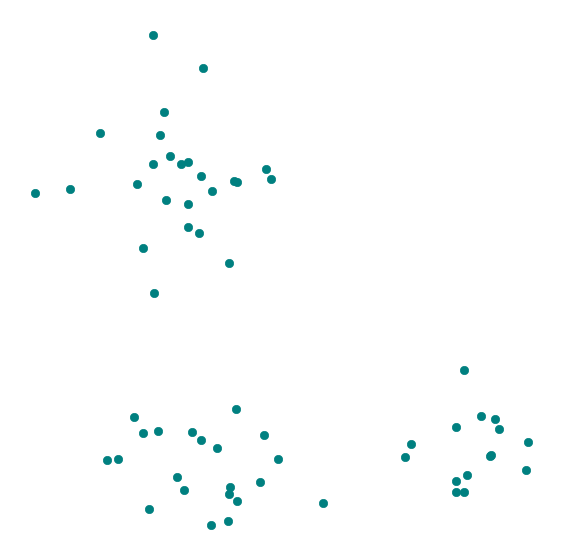

In [3]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], color="teal")
plt.axis('off')
plt.show()

Assigning the three clusters in this case does not exactly feel like rocket science. We could all do this manually with a pen in no time. So, why bother to use - let alone understand or develop - algorithms for this task?

There are two reasons why the shown figure makes the task look easy. First, the points are distributed in a way that immediately suggests clear boundaries or center positions. Obviously, not all cases will look that simple. More importantly, however, is that in most cases our datapoints will be nothing we can simply "look" at, or draw lines around because the data won't be two-dimensional. The number of features (or, in a table: columns) is what sets the number of dimensions of our data. And this will rarely ever be just two. But for datapoints which are 4D, 5D, 6D, 10D, or 100D, manually assigning clusters is not an option.

There are more reasons to rather search for a good algorithm than to assign clusters manually. Algorithms allow to cluster much larger datasets. And, in some cases, they will give consistent, reproducible results, i.e., they will assign each element the same cluster whenever we run the algorithm again. We will later see, that this is not true for all clustering algorithms.

### Why do we want to cluster data?

Clustering data serves as a fundamental technique in a data scientist's toolkit beyond simply managing multidimensional data. It facilitates the discovery of intrinsic patterns and structures hidden within data, particularly in high-dimensional datasets. These patterns reveal relationships, categories, and subclasses that may not be evident through direct observation, providing insights that are critical for informed decision-making.

Additionally, clustering helps to summarize large datasets by forming representative groups or clusters, making it more efficient for data compression and simplification. This simplification is essential for further analysis, visualization, and reporting. For example, in customer segmentation, clustering identifies groups of consumers with similar behaviors, enabling more targeted and effective marketing strategies.

Another crucial application of clustering is anomaly detection. By defining what constitutes 'normal' behavior within a cluster, it becomes easier to identify outliers or anomalies. These anomalies could indicate errors, fraud, or emergent phenomena, particularly relevant in areas like cybersecurity, where detecting unusual patterns can help preempt security breaches. We will see more on this in {numref}`ch_outliers`.

Clustering also acts as a preprocessing step for other analytical procedures. By organizing data into clusters, subsequent algorithms can operate more efficiently and with reduced computational costs within each cluster. This method enhances performance in complex processes such as image and speech recognition, where initial clustering helps streamline the analysis.

In summary, clustering is not merely a methodological convenience but a robust tool for extracting and leveraging the complex, multidimensional structures in data, which in turn enhances decision-making across various domains.

### Hard and Soft Clustering

Clustering usually involves assigning each data point to exactly one cluster, making it a binary, either-or decision. This type of clustering is known as hard clustering. However, there are scenarios where allowing data points to belong to multiple clusters is advantageous, known as soft clustering. An example of soft clustering is shown in {numref}fig_clustering_hard_soft. In this introductory text, unless specified otherwise, we will primarily discuss hard clustering, where each element belongs to one, and only one, cluster.

```{figure} ../images/fig_clustering_hard_soft.png
:name: fig_clustering_hard_soft

Two distinct approaches are defined in clustering: **hard clustering**, where an element is exclusively part of one cluster, and **soft clustering**, which allows elements to overlap among multiple clusters. This book generally focuses on hard clustering unless otherwise noted.
```

### Mini-exercise
**Team up with your neighbor (if in a class), or try on your own:**  
Examine at the data displayed in {numref}`fig_clustering_intro`. How would you design an algorithm to automatically assign each data point to a cluster it belongs to? Consider the following as you brainstorm:

- How can you determine the closeness of points to suggest they belong to the same cluster?
- What rules or criteria would you set for forming a cluster?

Make notes of your ideas and try to sketch out a simple algorithm or set of rules that could perform this clustering.

---

**What did you come up with?**

When I pose this question to students, I usually receive many different answers, many of which are viable approaches for the example shown.
Common strategies include:

- **Distance-based clustering**: Developing a rule based on the distance between points, where points are clustered together if they are within a certain distance from one another. This might involve calculating distances from every point to every other point or from points to a central location.
- **Geometric clustering**: Some students suggest fitting lines, borders, or shapes among the scatter points to form boundaries between clusters.
- **Density-based clustering**: Others propose methods that identify dense regions of points as individual clusters, possibly ignoring or separately categorizing outliers.

These diverse approaches highlight why numerous clustering algorithms have been developed, each with its own strengths and suitable applications. This exercise should help you appreciate the complexity of designing an algorithm that robustly and effectively identifies clusters in varied datasets

---
In the following, we will introduce and apply some very common clustering algorithms.

## KMeans Clustering

The K-means algorithm is a popular and intuitive method used for clustering and can be likened to the task of organizing similar items into buckets. To intuitively understand how it works, let’s imagine we are sorting fruit based on sweetness and size. Each fruit will be a data point with sweetness and size as its two features.

Here’s the step-by-step process:

1. **Initialization**: First, choose the number of buckets (clusters), say three for this fruit example. Begin by randomly selecting three fruits to act as the initial 'centroids' or representatives of these clusters.
2. **Assignment**: Assign each piece of fruit to the centroid it most closely resembles in terms of sweetness and size. The measurement of closeness could here be done based on the Euclidean distance between the features (sweetness and size).
3. **Update Centroids**: Once all fruits are assigned, recalculate each group's centroid by finding the average sweetness and size of the fruits in that group. These averages become the new centroids.
4. **Repeat Assignment and Update**: Steps 2 and 3 are repeated. Fruits may switch buckets if they’re closer to a different centroid after the update. New centroids are calculated after the reassignments.
5. **Convergence**: This process of assignment and updating continues until things settle down – that is, the fruits no longer switch buckets (clusters), and the centroids no longer change. This is called convergence.
6. **Result**: At the end, we have our fruits sorted into buckets where each fruit is surrounded by others with similar sweetness and size. Each bucket represents a cluster.

In a more technical context, the 'sweetness' and 'size' are analogs for the features of the dataset, and the 'average' fruit represents the mean of the cluster's points in feature space.

This iterative approach consists fundamentally of two steps: assigning data points to the nearest centroid and recalculating centroids. Despite its straightforward nature, KMeans has some limitations that need consideration.

```{figure} ../images/fig_kmeans_sketch.png
:name: fig_kmeans

Illustrative diagram of the K-means clustering process, showcasing the initialization of centroids, assignment of points to the nearest centroids, updating of centroids based on the assigned points, and the iterative process until convergence.
```

### Advantages of KMeans:

- **Simplicity**: The algorithm is easy to understand and implement.
- **Efficiency**: It is computationally efficient, making it suitable for large datasets.
- **Effectiveness**: Performs well with clusters that are relatively isotropic and similar in size.

### Disadvantages of KMeans:

- **Fixed Number of Clusters**: Requires specifying the number of clusters beforehand, which is not always known in advance and can be difficult to estimate.
- **Cluster Assumptions**: Assumes that clusters are spherical and of similar size, which may not hold true for all datasets.
- **Sensitivity to Initial Conditions**: The initial placement of centroids can affect the final outcome, and KMeans can sometimes converge to a local minimum rather than the global best solution.
- **Outlier Sensitivity**: Outliers can skew the centroids, making KMeans less robust to anomalous data points.

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

C:\Users\flori\anaconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We visualize the resulting clustering. Each cluster is shown with a different color.

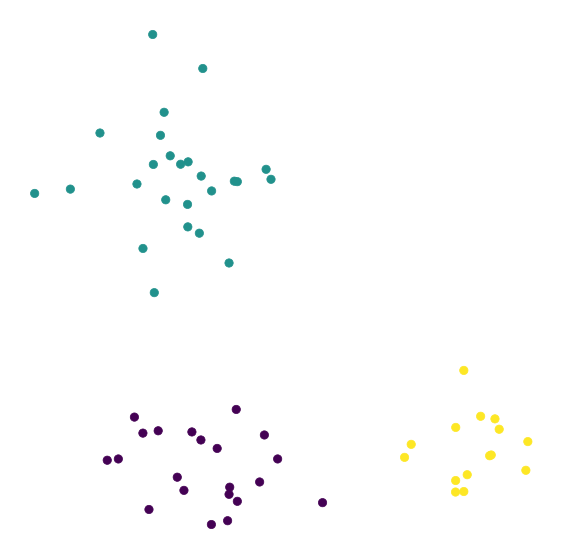

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=kmeans.labels_)

plt.axis("off")
#plt.savefig("example_clustering_00_clusters.png", dpi=300)
plt.show()

### Very often, clusters are not that easily distinguishable!
In the following code blocks we create a new synthetic dataset with five clusters, and visualize it.
This is already one step more "realistic" in the sense that most commonly we do not deal with ideally distinctive clusters an shown in the examples above. Very often is is not so clear where a cluster begins and where one ends, nor how many clusters we actually have. 

In [6]:
clusters = [(61, 1, 1.5, 2.5, -0.7),
           (37, 0.8, 0.5, 1.1, -1.2),
           (49, 1.1, 1.2, -2.6, 2.3),
           (44, 0.45, 0.4, 0.5, 2.3),
           (70, 0.9, 0.3, -2.5, -1.7)]

np.random.seed(1)
data = np.zeros((0, 2))
for (n_points, x_scale, y_scale, x_offset, y_offset) in clusters:
    xpts = np.random.randn(n_points) * x_scale + x_offset
    ypts = np.random.randn(n_points) * y_scale + y_offset
    data = np.vstack((data, np.vstack((xpts, ypts)).T))

In [7]:
data.shape

(261, 2)

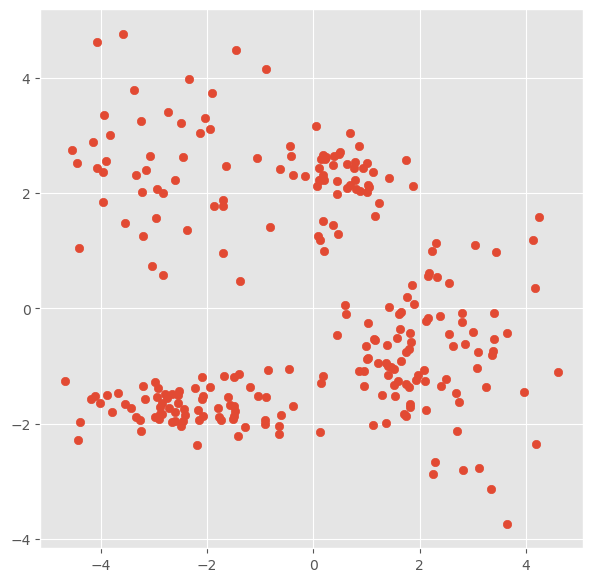

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1])
# plt.savefig("example_clustering_01.png", dpi=300, bbox_inches="tight")

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(data)
kmeans.labels_

C:\Users\flori\anaconda3\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([4, 4, 1, 1, 4, 0, 4, 0, 1, 1, 4, 1, 4, 4, 1, 1, 4, 1, 4, 4, 1, 4,
       4, 4, 4, 1, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4,
       4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 4, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 0, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [10]:
kmeans.cluster_centers_

array([[ 0.42175481,  2.27101038],
       [ 1.6215401 , -1.2506384 ],
       [-2.34187934, -1.65931661],
       [-2.99127157,  2.52658441],
       [ 2.96607164, -0.10142692]])

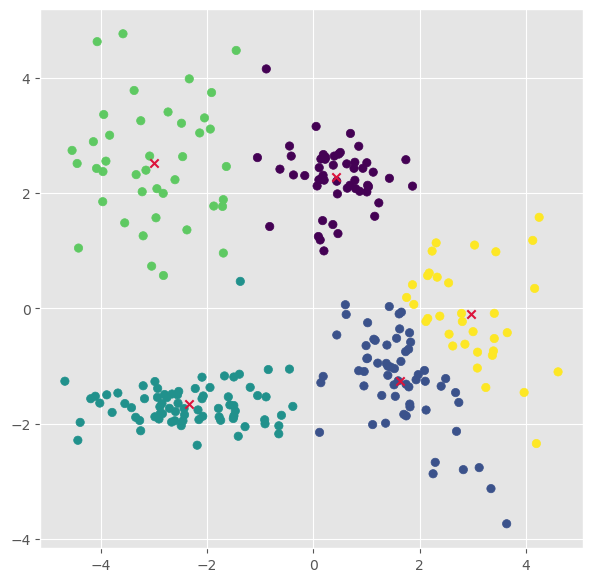

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=kmeans.labels_)
ax.scatter(kmeans.cluster_centers_[:, 0],
          kmeans.cluster_centers_[:, 1], marker="x", color="crimson")

#plt.savefig("example_clustering_01_kmeans.png", dpi=300, bbox_inches="tight")

In [12]:
kmeans.predict([[-2, 0], [4, 3]])

array([2, 4])

In [13]:
kmeans.cluster_centers_

array([[ 0.42175481,  2.27101038],
       [ 1.6215401 , -1.2506384 ],
       [-2.34187934, -1.65931661],
       [-2.99127157,  2.52658441],
       [ 2.96607164, -0.10142692]])

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It's like an adventurous hike where we group together hikers based on how closely they walk together and how often they stop to rest. To explain DBSCAN in an accessible way, let's consider our hikers as data points in a park (our dataset).

**How DBSCAN works:**

1. **Starting Point (Core Points)**:  First, select a hiker and check how many others are within a preset distance (`epsilon`). If a sufficient number (defined by `min_samples`) are within this range, this hiker becomes a core of a potential cluster.
2. **Forming Groups (Cluster Expansion)**: From our core hiker, we extend the group by asking each new hiker in the epsilon area to invite other hikers within their own epsilon area. If these hikers also have enough companions within their reach, the group grows – this is how DBSCAN expands clusters.
3. **Connecting Groups (Density Reachability)**: Sometimes, a hiker might not have enough people within their epsilon distance to form their own core group but is close enough to be part of the existing group. These hikers act as bridges and help in joining different core groups, forming a larger cluster.
4. **Identifying Lone Hikers (Noise Detection)**: Some hikers prefer solitude and are too far from others to join any group. These are labeled as 'noise'—similar to outliers in data.
5. **Adapting to Terrain (Handling Different Densities)**: Just as groups of hikers might spread out in open fields and bunch up in narrow trails, DBSCAN tries to adapt to areas of different point densities. This can be tricky because the same 'epsilon' and `min_samples` might not work for both sparse and dense areas, which is a challenge for DBSCAN.
6. **Exploring the Entire Park (Full Dataset)**: The process continues until all hikers are either grouped or labeled as noise. Unlike K-means, we don’t need to know how many groups (clusters) we want to form in advance – the hikers (data points) naturally form groups based on their proximity and the number of companions they have.

DBSCAN is particularly effective for complex datasets with non-linear cluster shapes and varying densities. However, the choice of `epsilon` and `min_samples` is crucial, as it significantly impacts the clustering results.

### Advantages of DBSCAN:

- **Adaptive Clustering**: Automatically determines the number of clusters based on data density, eliminating the need to predefine this number.
- **Handles Arbitrary Shapes**: Efficiently identifies clusters of various shapes, adapting to the actual distribution of data points.
- **Outlier Detection**: Effectively differentiates between core clusters and noise, enhancing its robustness against outliers.

### Disadvantages of DBSCAN:

- **Sensitivity to Parameters**: Highly dependent on the settings for `epsilon` and `min_samples`, which can significantly impact clustering outcomes.
- **Struggles with Varying Densities**: May fail to accurately define clusters when they vary widely in density, treating sparse clusters as noise.
- **Computational Complexity**: While generally efficient, its performance may degrade with very large datasets or those with high dimensionality due to the complexity of density calculations.

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=2).fit(data)

In [15]:
dbscan.labels_

array([ 0,  1,  1,  1,  1,  2,  0,  3,  4,  5, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  4,  1,
        1,  1,  1,  5,  1,  4,  6,  1,  1,  1,  1,  1,  7,  1,  1,  1,  8,
        1,  1,  1, -1,  1,  1,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,  9,  9, 10, -1,
       11, 10, 12,  7, -1, 13, -1, -1, 13,  3, 12, 13, -1, -1, -1, -1,  9,
       12,  3, 12, -1,  9, -1,  9, 13,  2, 12, 11, -1, 12,  9, -1, 10,  3,
        9, 13, 13, 12, 13, -1, 12, 12, 12, 13, 12,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3, -1,  3,
        3,  3,  3,  3,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7, -1,  7,  7

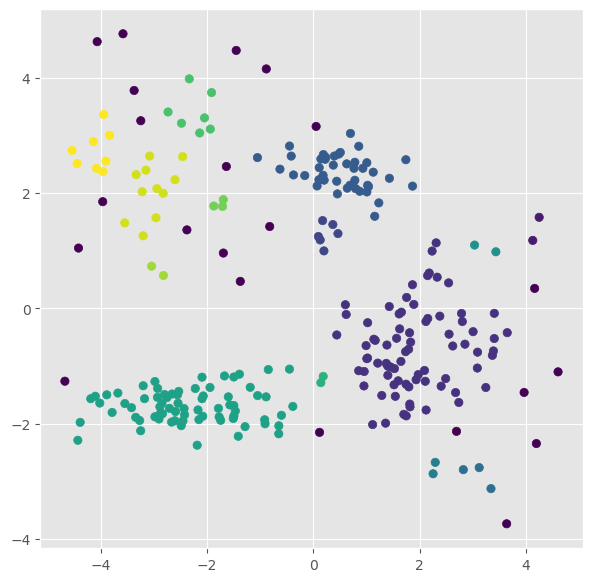

In [16]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=dbscan.labels_)

plt.savefig("example_clustering_01_dbscan_eps_05.png", dpi=300,
           bbox_inches="tight")

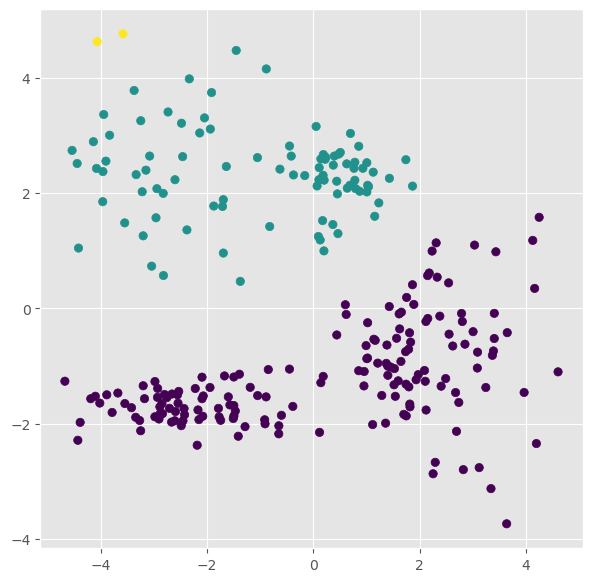

In [17]:
dbscan = DBSCAN(eps=1, min_samples=2).fit(data)

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=dbscan.labels_)

# plt.savefig("example_clustering_01_dbscan_eps_1.png", dpi=300, bbox_inches="tight")

## Gaussian mixture models
Gaussian Mixture Models (GMM) can be thought of as a sophisticated extension of the K-means clustering technique, with added flexibility. If we were to visualize data clustering as a process of sorting different types of coins based on their size and weight, K-means would sort them into predefined buckets, while GMM would be like having scales and calipers that tell us not just which bucket a coin most likely belongs to, but also provide a measure of our certainty about it.

**How GMM works:**

1. **Assumptions**: GMM starts with the assumption that our data points are generated from a mixture of several Gaussian distributions. Each Gaussian, also known as a normal distribution, represents a cluster. It’s like assuming that coins come from different countries, each with its unique size and weight characteristics.
2. **Expectation-Maximization (EM) Steps**:
   - **Expectation (E-step)**: Here, the algorithm assesses each data point and estimates the probabilities of it belonging to each of the Gaussian distributions (clusters). In our coin analogy, this is like guessing the origin of a coin based on its size and weight, but instead of being certain, we assign probabilities to the likelihood of it coming from each country.
   - **Maximization (M-step)**: Based on these probabilities, GMM updates the parameters of the Gaussian distributions—namely, the means (which are like the centroid in K-means), the variances (which tell us how spread out each cluster is), and the mixture weights (which tell us how large or small each cluster is compared to others). This is akin to adjusting our scale and calipers based on all the coins we've measured to better fit the actual data.
3. **Iterative Process**: These two steps are repeated iteratively, with each pass refining the parameters and improving the model's accuracy in representing the underlying clusters.
4. **Soft Clustering**: Unlike K-means, which assigns each point to a single cluster, GMM provides a probability distribution over the clusters for each point, indicating its degree of membership in every cluster. This soft assignment is particularly useful when we’re not sure about the boundaries of clusters, much like a coin that’s in-between typical sizes and weights for known designs.
5. **Final Model**: After several iterations, when the changes in the parameters become negligible, the algorithm has hopefully converged to the best fit for our data, and we have a final model that tells us not only where the clusters are, but also how certain we can be about each data point's membership.

### Advantages of GMM:

- **Flexibility**: GMM can accommodate clusters of various shapes, sizes, and orientations, making it more versatile than simpler methods like K-means.
- **Soft Clustering**: It provides a probabilistic model of cluster membership, offering a nuanced view of each data point's placement.

### Disadvantages of GMM:

- **Number of Clusters**: Like K-means, GMM requires the user to predetermine the number of clusters, which can be challenging without prior knowledge of the dataset.
- **Computational Intensity**: It is generally more computationally demanding than K-means due to the complexity of its calculations.
- **Data Requirements**: GMM necessitates a sufficiently large data set to effectively estimate the parameters of Gaussian distributions.

In [18]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=5, random_state=0).fit(data)

In [19]:
gm.means_

array([[-2.80121071,  2.49623595],
       [ 2.08237568, -0.79412545],
       [-2.96321278, -1.69907782],
       [ 0.49887671,  2.26838731],
       [-1.43864991, -1.67923165]])

In [20]:
labels = gm.predict(data)

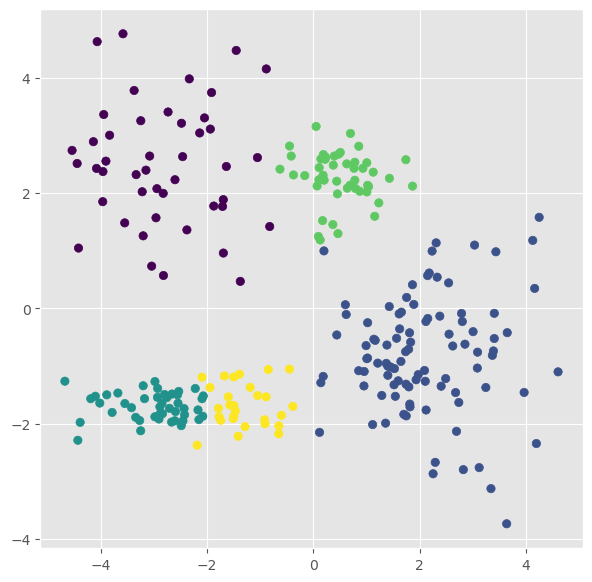

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=labels)
# plt.savefig("example_clustering_01_gaussian_mixture.png", dpi=300, bbox_inches="tight")

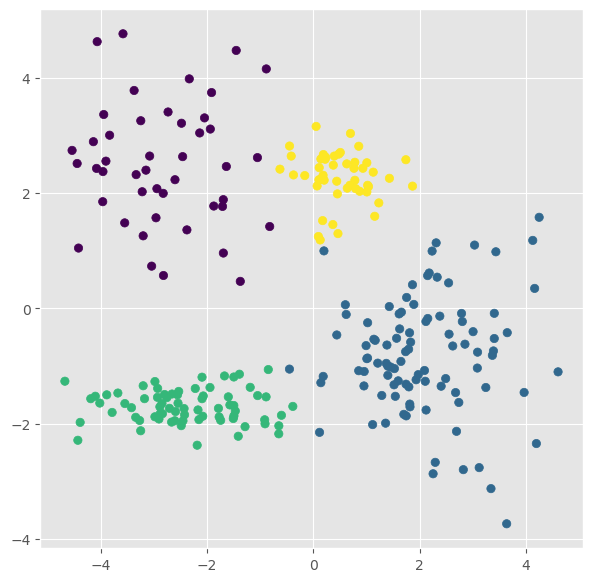

In [22]:
gm = GaussianMixture(n_components=4, random_state=0).fit(data)
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=gm.predict(data))
# plt.savefig("example_clustering_01_gaussian_mixture_c4.png", dpi=300, bbox_inches="tight")

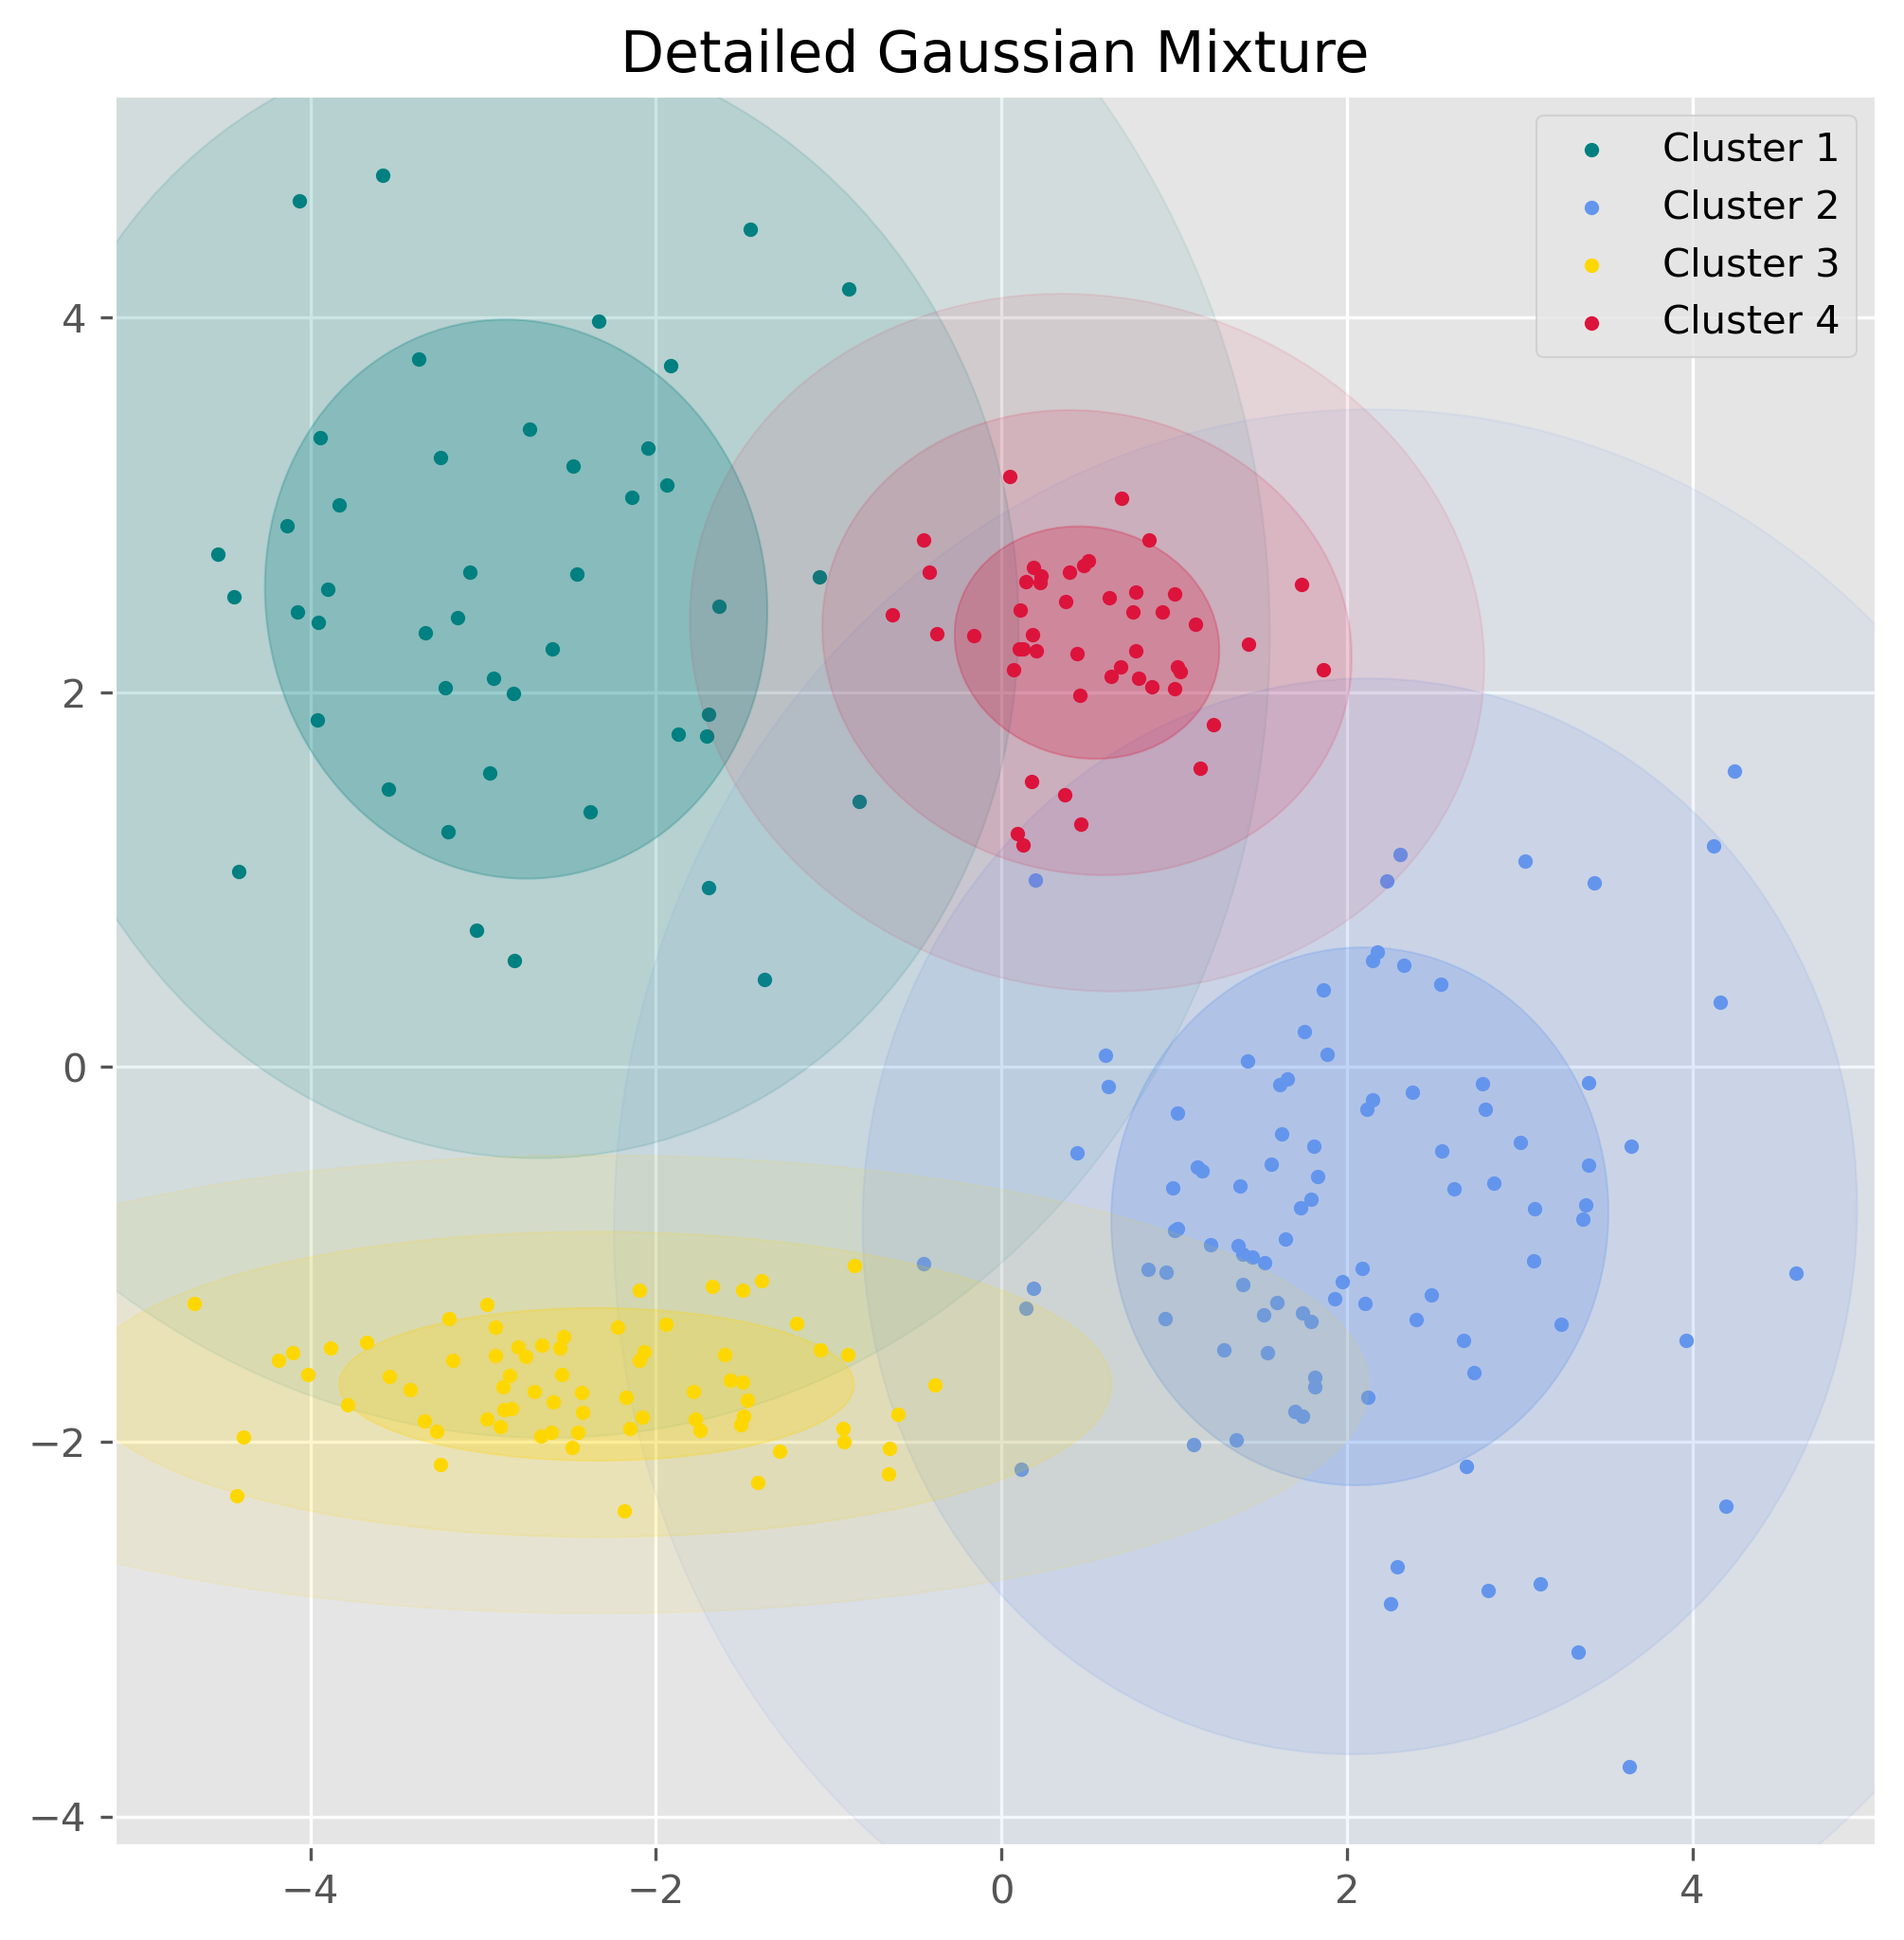

In [29]:
from matplotlib.patches import Ellipse
from scipy import linalg
import itertools

# Color iterator for different clusters
color_iter = itertools.cycle(['teal', 'cornflowerblue', 'gold', 'crimson', 'c'])

def plot_gmm(X, Y_, means, covariances, title):
    """Plot the Gaussian Mixture Model with multiple ellipses to show the distribution density."""
    plt.figure(figsize=(8, 8), dpi=300)
    ax = plt.gca()

    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        if not np.any(Y_ == i):
            continue

        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=10, color=color, label=f'Cluster {i+1}')

        # Calculate the eigenvalues and eigenvectors for the covariance matrix
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)

        # Calculate the angle of the ellipse
        u = w[0] / linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180. * angle / np.pi  # Convert to degrees

        # Plot ellipses at 1 std, 2 std, and 3 std
        for std_dev in range(1, 4):
            ell = Ellipse(mean, std_dev * v[0], std_dev * v[1], angle=180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.25 / std_dev)  # Decrease alpha as std_dev increases
            ax.add_artist(ell)

    #plt.xticks([])
    #plt.yticks([])
    plt.title(title)
    plt.legend()
    plt.show()

# Run plotting function
plot_gmm(data, gm.predict(data), gm.means_, gm.covariances_, "Detailed Gaussian Mixture")

## Hierarchical clustering (Ward)
Hierarchical clustering, especially the Ward method, can be visualized as creating a family tree of data points, showing the relationships between clusters from the ground up. Imagine organizing a large collection of books on shelves to understand this concept better.

### How Hierarchical Clustering Works:

1. **Initialization (Every Book as a Cluster)**: Initially, each book is treated as its own cluster. This bottom-up approach starts with every item in its own group.
2. **Agglomeration (Creating Shelves)**: Books are grouped based on similarity, typically measured by the distance between them. The Ward method minimizes within-cluster variance, aiming to place books of similar sizes or genres together for a neater arrangement.
3. **Building the Hierarchy (Forming Sections)**: As books are grouped, we begin to see not just individual books or pairs, but larger groups and subgroups, each akin to a branch on a family tree of book categories.
4. **Creating the Dendrogram (Forming a Library)**: The process continues until all books are grouped in a way that illustrates their relationships, from individual books to entire genre sections. This is represented by a dendrogram—a tree-like diagram that records the sequences of merges.
5. **Determining the Number of Clusters (Deciding on Genres)**: A key advantage of hierarchical clustering is that it does not require a predetermined number of clusters. Once the dendrogram is complete, we can 'cut' it at a level that makes sense, choosing either broad genres or specific sub-genres based on our requirements.

### Advantages of Hierarchical Clustering:

- **Flexibility in Number of Clusters**: Unlike many clustering techniques, hierarchical clustering doesn’t compel us to decide on the number of clusters at the start. This decision can be made by analyzing the dendrogram at different cuts.
- **Visual Insights**: It provides a visual representation of the data hierarchy, which can be incredibly insightful for understanding the relationships between clusters.

### Disadvantages of Hierarchical Clustering:

- **Computational Intensity**: This method can be computationally demanding, particularly with large datasets. It’s akin to manually organizing an extensive library.
- **Irreversibility of Merges**: Once made, early decisions in the agglomerative process cannot be undone without restarting, which can sometimes lead to suboptimal clustering.
- **Decision on Cluster Cut**: Despite not needing to predefine the number of clusters, a criterion is still required to decide where to cut the dendrogram, which effectively determines the final number of clusters.

In [28]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage="ward",
                              n_clusters=None,
                              distance_threshold=10.0).fit(data)

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


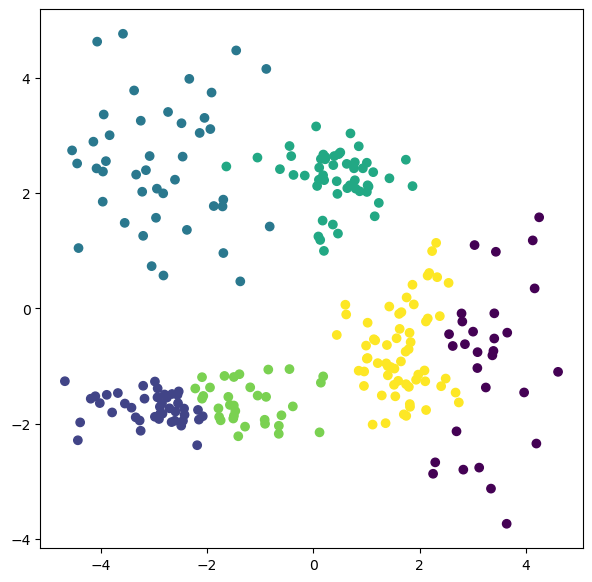

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=ward.labels_)
# plt.savefig("example_clustering_01_hierarchical_ward.png", dpi=300, bbox_inches="tight")

In [30]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage="ward",
                              n_clusters=None,
                              distance_threshold=2.0).fit(data)

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


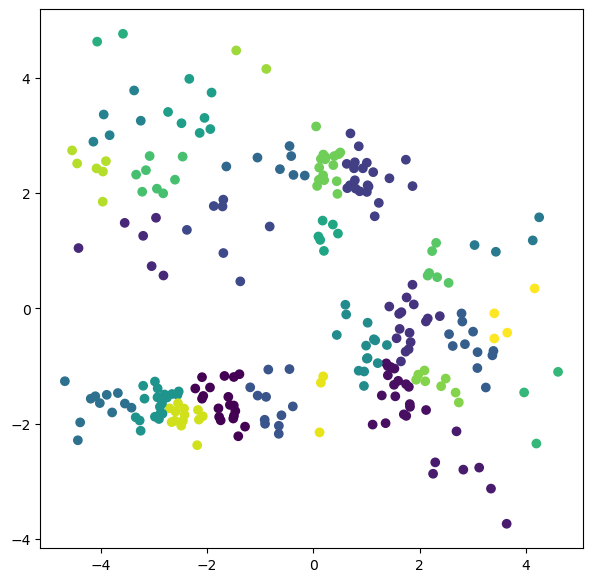

In [31]:
gm = GaussianMixture(n_components=4, random_state=0).fit(data)
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=ward.labels_)
#plt.savefig("example_clustering_01_hierarchical_ward_dist2.png", dpi=300, bbox_inches="tight")

## Comparison and Conclusion

In this section, we have explored four different clustering algorithms: K-means, DBSCAN, Gaussian Mixture Model (GMM), and hierarchical clustering.  Each method offers unique advantages and comes with its own set of limitations.

**K-means** is a simple and easy-to-understand algorithm that works well with isotropic clusters. Its limitations include the requirement to predefine the number of clusters, sensitivity to initial conditions, and a tendency to converge to a local minimum rather than the global optimum.

**DBSCAN** stands out for not requiring the number of clusters to be specified and for its ability to identify clusters of arbitrary shapes and robustness to noise. However, DBSCAN may struggle with clusters of varying densities, and the choice of hyperparameters (epsilon and min_samples) can significantly affect the results.

**Gaussian Mixture Models (GMM)** provide a probabilistic framework that assumes each cluster follows a Gaussian distribution, offering greater flexibility than K-means in terms of cluster covariance. While GMM can model clusters of different shapes, sizes, and orientations, it requires specification of the number of clusters and is more computationally intensive.

**Hierarchical Clustering** builds a hierarchy of clusters, either agglomerative (bottom-up) or divisive (top-down), with the Ward method being an example that minimizes the within-cluster variance. This method doesn’t require specifying the number of clusters, offering a visual dendrogram to aid in cluster selection, though it is computationally expensive for large datasets.

In conclusion, the choice of clustering algorithm depends on the data, the problem, and the desired characteristics of the clustering solution. It is often helpful to try multiple algorithms and compare their results to select the best method for a particular problem.

In [32]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

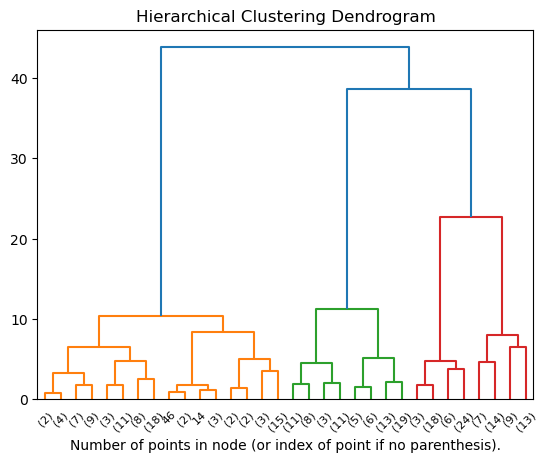

In [33]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ward, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

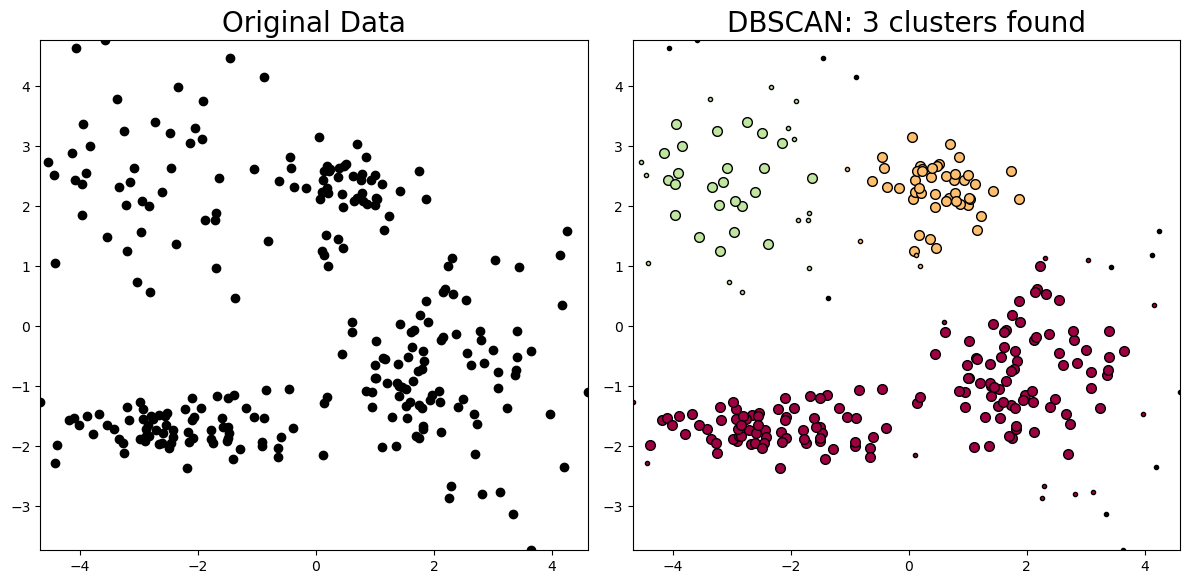

In [34]:
max_distance = 1
db = DBSCAN(eps=max_distance, min_samples=10).fit(data)
# Extract a mask of core cluster members
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Extract labels (-1 is used for outliers)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

# Plot up the results!
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'ko')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Original Data', fontsize = 20)

plt.subplot(122)
# The following is just a fancy way of plotting core, edge and outliers
# Credit to: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)